In [1]:
#Expand notebook to take full screen width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

#Jupyter magic to notify when a cell finishes execution with %%notify command -- does not work with Jupyterlab
import jupyternotify
ip = get_ipython()
ip.register_magics(jupyternotify.JupyterNotifyMagics)

###
import sys
sys.path.insert(0,'../../src/')

%load_ext autoreload
%autoreload 2

#%pdb

<IPython.core.display.Javascript object>

In [29]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
from torch.nn.modules import Module
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import copy
import pickle
import model_archs

from utils_plot import show_sws_weights, show_weights, print_dims, prune_plot, draw_sws_graphs, joint_plot, plot_data, show_sws_weights_log
from utils_model import test_accuracy, train_epoch, retrain_sws_epoch, model_prune, get_weight_penalty, layer_accuracy
from utils_misc import trueAfterN, logsumexp, root_dir, model_load_dir, get_ab, get_sparsity
from utils_sws import GaussianMixturePrior, special_flatten, KL, compute_responsibilies, merger, sws_prune, sws_prune_l2, sws_prune_copy
from mnist_loader import search_train_data, search_retrain_data, search_validation_data, train_data, test_data, batch_size
from extract_targets import get_targets
from retrain_layer import init_retrain_layer
from retrain_model import retrain_model

test_data_full = Variable(test_data(fetch='data')).cuda()
test_labels_full = Variable(test_data(fetch='labels')).cuda()

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle

retraining_epochs = 50

### Exps

1. Anneal Tau
2. Try SWS Targets on LeNet-300-100
3. Capture MSEST Loss

In [71]:
def mse_loss(input, target):
    return torch.sum((input - target).pow(2)) / input.numel()

/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:2: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  from ipykernel import kernelapp as app


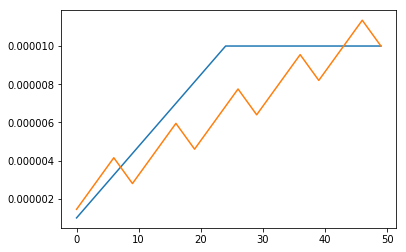

In [72]:
def tau_warmup(tmax, tmin, epochs):
    x = np.linspace(tmin, tmax, epochs/2)
    tausch = np.concatenate([x, np.ones(epochs - len(x)) * tmax])
    return list(tausch)
plt.plot(tau_warmup(1e-5, 1e-6, 50))

def sawtooth(tmax, tmin, epochs, upratio, cycle):
    gup = cycle * upratio
    gdown = cycle * (1-upratio)
    step_grad = (tmax-tmin)/ (epochs*( 2 * upratio - 1))
    v = tmin
    l=[]
    for i in range (int(epochs/cycle)):
        for j in range (int(gup)):
            v += step_grad
            l.append(v)
        for j in range (int(gdown)):
            v -= step_grad
            l.append(v)
    return l
plt.plot(sawtooth(1e-5, 1e-6, 50, 0.7, 10))

def get_loss (data, targets, model, temp, loss_type=""):
    forward = model(data)
    outputs = nn.Softmax(dim=1)(forward/temp).data
    loss_acc = mse_loss(outputs, targets) * temp ** 2
    return loss_acc

In [73]:
def retrain_model(mean, var, zmean, zvar, tau, temp, mixtures, model_name, data_size, loss_type = 'MSESNT', scaling = False, model_save_dir = "",  fn="", dset="mnist", tscd="const"):
    ab = get_ab(mean, var)
    zab = get_ab(zmean, zvar)
    
    model_file = '{}_{}_{}_{}'.format(dset, model_name, 100, data_size)
    model = torch.load(model_load_dir + model_file + '.m').cuda()
    
    train_dataset = train_data
    test_data_full = Variable(test_data(fetch='data', dset=dset)).cuda()
    test_labels_full = Variable(test_data(fetch='labels', dset=dset)).cuda()
    test_targets_full = model(test_data_full)
    train_data_full = Variable(train_data(fetch='data', dset=dset)).cuda()
    
    test_output = model(test_data_full)
    test_output = (nn.Softmax(dim=1)(test_output/temp)).data
    
    #Same Model Targets
    output = torch.load("{}{}_targets/{}.out.m".format(model_load_dir, model_file, "fc3" if "300_100" in model.name else "fc2"))
    #SWS Targets
    #output = torch.load("{}{}_{}_targets/{}.out.m".format(model_load_dir, dset, "SWSModel_100_full", "fc2")) #Use SWSModel targets
    output = (nn.Softmax(dim=1)(output/temp)).data
    dataset = torch.utils.data.TensorDataset(train_dataset(fetch='data', dset=dset), output)
    loader = torch.utils.data.DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)
    
    s = "s" if scaling else "f" 
    exp_name = "{}_m{}_zm{}_r{}_t{}_m{}_kdT{}_{}_{}".format(model.name, mean, zmean, retraining_epochs, tau, int(mixtures), int(temp), s, data_size) + fn
    gmp = GaussianMixturePrior(mixtures, [x for x in model.parameters()], 0.99, zero_ab = zab, ab = ab, scaling = scaling)
    gmp.print_batch = False
    
    if (tscd=="const"):
        tauscd = tau_warmup(1e-5, 1e-5, retraining_epochs)
    if (tscd=="warmup"):
        tauscd = tau_warmup(1e-5, 1e-6, retraining_epochs)
    if (tscd=="sawtooth"):
        tauscd = sawtooth(1e-5, 1e-6, retraining_epochs, 0.7, 10)

    optimizable_params = [
        {'params': model.parameters(), 'lr': 2e-4},
        {'params': [gmp.means], 'lr': 0.5e-4},
        {'params': [gmp.gammas, gmp.rhos], 'lr': 3e-3}]
    if (scaling):
        optimizable_params = optimizable_params + [{'params': gmp.scale, 'lr': 1e-6}]
    opt = torch.optim.Adam(optimizable_params)#log precisions and mixing proportions

    res_stats = plot_data(init_model = model, gmp = gmp, mode = 'retrain', data_size = data_size, loss_type='CE', mv = (mean, var), zmv = (zmean, zvar), tau = tau, temp = temp, mixtures = mixtures, dset = dset)
    s_hist = a_hist = test_loss = train_loss = []
    
    test_loss.append(float(get_loss(test_data_full, test_output, model, temp)[0].cpu()))
    train_loss.append(float(get_loss(train_data_full, output, model, temp)[0].cpu()))
    
    for epoch in range(retraining_epochs):
        tau = tauscd[epoch]
        model, loss = retrain_sws_epoch(model, gmp, opt, loader, tau, temp, loss_type)
        res_stats.data_epoch(epoch + 1, model, gmp)
        
        test_loss.append(float(get_loss(test_data_full, test_output, model, temp)[0].cpu()))
        train_loss.append(float(get_loss(train_data_full, output, model, temp)[0].cpu()))

        if (trueAfterN(epoch, 10)):
            nm = sws_prune_copy(model, gmp)
            s = get_sparsity(nm)
            a = test_accuracy(test_data_full, test_labels_full, nm)[0]

            print('Epoch: {}. Test Accuracy: {:.2f}, Prune Accuracy: {:.2f}, Sparsity: {:.2f}'.format(epoch+1, res_stats.test_accuracy[-1], a, s))
            #show_sws_weights(model = model, means = list(gmp.means.data.clone().cpu()), precisions = list(gmp.gammas.data.clone().cpu()), epoch = epoch)###
        nm = sws_prune_copy(model, gmp)
        s = get_sparsity(nm)
        a = test_accuracy(test_data_full, test_labels_full, nm)[0]
        s_hist.append(s)
        a_hist.append(a)
        
    model_prune = sws_prune_copy(model, gmp)

    res_stats.data_prune(model_prune)
    res = res_stats.gen_dict()
    res['test_prune_acc'] = a_hist
    res['test_prune_sp'] = s_hist
    res['test_loss_mse'] = test_loss
    res['train_loss_mse'] = train_loss

    print('Retrain Test: {:.2f}, Prune Test: {:.2f}, Prune Sparsity: {:.2f}'.format(res['test_acc'][-1], res['prune_acc']['test'],res['sparsity']))

    if(model_save_dir!=""):
        torch.save(model, model_save_dir + '/{}_retrain_model_{}.m'.format(dset, exp_name))
        with open(model_save_dir + '/{}_retrain_gmp_{}.p'.format(dset, exp_name),'wb') as f:
            pickle.dump(gmp, f)
        with open(model_save_dir + '/{}_retrain_res_{}.p'.format(dset, exp_name),'wb') as f:
            pickle.dump(res, f)

    return model, gmp, res

In [74]:
model, gmp, res = retrain_model(100, 10, 2500, 1250, 1e-6, 4, 16, "LeNet_300_100", "full", 'MSEST', False, "", dset="mnist")

/anaconda/envs/py35/lib/python3.5/site-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'model_archs.LeNet_300_100' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 100.0 Variance: 10.0


/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:2: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  from ipykernel import kernelapp as app


TypeError: 'float' object is not subscriptable

### SWS Targets

In [30]:
model, gmp, res = retrain_model(250, 10, 2500, 1250, 1e-6, 5, 16, "LeNet_300_100", "full", 'MSEST', False, "", dset="mnist")

/anaconda/envs/py35/lib/python3.5/site-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'model_archs.LeNet_300_100' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 250.0 Variance: 10.0
Epoch: 10. Test Accuracy: 98.26, Prune Accuracy: 89.67, Sparsity: 73.68
Epoch: 20. Test Accuracy: 97.59, Prune Accuracy: 96.97, Sparsity: 92.93
Epoch: 30. Test Accuracy: 97.85, Prune Accuracy: 97.46, Sparsity: 96.75
Epoch: 40. Test Accuracy: 98.06, Prune Accuracy: 97.71, Sparsity: 97.23
Epoch: 50. Test Accuracy: 98.07, Prune Accuracy: 97.68, Sparsity: 97.25
Retrain Test: 98.07, Prune Test: 97.68, Prune Sparsity: 97.25


In [38]:
model, gmp, res = retrain_model(100, 10, 2500, 1250, 0.8e-6, 4, 16, "LeNet_300_100", "full", 'MSEST', False, "", dset="mnist")

/anaconda/envs/py35/lib/python3.5/site-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'model_archs.LeNet_300_100' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


0-component Mean: 2500.0 Variance: 1250.0
Non-zero component Mean: 500.0 Variance: 10.0
Epoch: 10. Test Accuracy: 98.24, Prune Accuracy: 96.64, Sparsity: 71.74
Epoch: 20. Test Accuracy: 97.57, Prune Accuracy: 97.36, Sparsity: 97.09
Epoch: 30. Test Accuracy: 97.82, Prune Accuracy: 97.17, Sparsity: 97.10
Epoch: 40. Test Accuracy: 97.95, Prune Accuracy: 97.24, Sparsity: 97.15
Epoch: 50. Test Accuracy: 97.98, Prune Accuracy: 97.44, Sparsity: 97.18
Retrain Test: 97.98, Prune Test: 97.44, Prune Sparsity: 97.18


In [ ]:
model, gmp, res = retrain_model(100, 10, 2500, 1250, 0.8e-6, 4, 16, "LeNet_300_100", "full", 'MSEST', False, "", dset="mnist")

In [39]:
model_file = '{}_{}_{}_{}'.format("mnist", "LeNet_300_100", 100, "full")
model_orig = torch.load(model_load_dir + model_file + '.m').cuda()
test_output = model_orig(test_data_full)
test_output = Variable((nn.Softmax(dim=1)(output/5)).data, requires_grad = False)
#output = torch.load("{}{}_targets/fc3.out.m".format(model_load_dir, "mnist_LeNet_300_100_100_full", "fc3" if "300_100" in model.name else "fc2"))


/anaconda/envs/py35/lib/python3.5/site-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'model_archs.LeNet_300_100' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [41]:
get_loss(test_data_full, output, model, 5)

Variable containing:
1.00000e-02 *
  4.1783
[torch.cuda.FloatTensor of size 1 (GPU 0)]